In [90]:
import os, json
import pickle
import pandas as pd
import numpy as  np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp
from sklearn.metrics import classification_report

In [91]:
# !pip install pymc

In [92]:
# ! pip install arviz

In [93]:
# !pip install graphviz

In [94]:
# !apt-get install graphviz -y

## Data

In [95]:
DATA_PATH='data/raw/'
df=pd.DataFrame()
for file in os.listdir(DATA_PATH):
    df_=pd.read_csv(f'{DATA_PATH}{file}')
    df=pd.concat([df, df_])
df.shape

(180524, 13)

In [96]:
df.head(10)

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
0,fb6f44a4e71821f2,2023-01,Valga,B,101,osaühing Kursus & Ko,E,bf2b7218d36e2a3d,MITTE_SOORITATUD,28.0,NaN,LIIKLUSOHUTUS|TEELPUSIMINE,NaN
1,82ed52e5990f8204,2023-01,Jõgeva,B,101,OÜ AUTOSÕIT,E,844452b4e4bac2ef,SOORITATUD,44.0,NaN,NaN,NaN
2,e72eeaf255d74785,2023-01,Narva,B,101|78,OSAÜHING ERMAN AUTOKOOL,E,d67d168bc8d04278,SOORITATUD,45.0,NaN,NaN,NaN
3,d0dd38daf0397c9d,2023-01,Valga,B,101,osaühing Kursus & Ko,J,bf2b7218d36e2a3d,MITTE_SOORITATUD,33.0,NaN,LIIKLUSOHUTUS,NaN
4,655194a10a21cd56,2023-01,Paide,B,101|78,Autokool Drive OÜ,E,f6097462dafbd97c,MITTE_SOORITATUD,18.0,NaN,PARKIMINE_MANOOVRIGA,EBAPIISAV_ETTEVALMISTUS|PARKIMINE_MARGISEL
5,761396cbfe80ec42,2023-01,Valga,B,101,osaühing Kursus & Ko,E,faeaf99580d6be30,SOORITATUD,42.0,NaN,NaN,NaN
6,de824d8083a1d269,2023-01,Rapla,B,101,Silver Autokool OÜ,E,4b9e369e12d8f969,SOORITATUD,49.0,NaN,NaN,NaN
7,44e0c0d162afebb0,2023-01,Narva,B,101,Osaühing STALIKA-VEOD,E,166c8268fe1b2ec1,SOORITATUD,41.0,NaN,NaN,NaN
8,808f4666542a6bc8,2023-01,Narva,B,101,Mittetulundusühing Autobis,E,166c8268fe1b2ec1,MITTE_SOORITATUD,47.0,NaN,LIIKLUSOHUTUS|PARKIMINE_MANOOVRIGA,OHUSTAMINE
9,cdc8a8cc2ddeca47,2023-01,Tartu,B,101|78,ROPKA ERAKOOL OÜ,NaN,c68c6310b2fe1124,EI_ILMUNUD_KOHALE,NaN,EI_ILMUNUD,NaN,NaN


In [97]:
df.tail(10)

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
43899,2d3d0275e6f87c93,2024-01,Tallinn,C,NaN,Aktsiaselts Odium,E,a1d9e404aeec83d1,SOORITATUD,58.0,NaN,NaN,NaN
43900,662c8bfc52935409,2024-08,Tartu,C,NaN,OÜ AUTOSÕIT,E,b89f5e763b05e7a7,MITTE_SOORITATUD,4.0,NaN,TAGUR_BOKS,VASTU_KOONUST
43901,8431c357abeb9177,2024-05,Tallinn,A,NaN,Ametikoolitus OÜ,E,b353c311e671711a,SOORITATUD,44.0,NaN,NaN,NaN
43902,41f599b18e8d11a3,2024-09,Rapla,A,NaN,Rapla Autokool OÜ,E,b353c311e671711a,SOORITATUD,43.0,NaN,NaN,NaN
43903,7ba322b8b5eb8552,2024-02,Pärnu,CE,NaN,osaühing Aide Autokool,E,c347692cf48342d6,SOORITATUD,64.0,NaN,NaN,NaN
43904,2455ec4557fca42a,2024-02,Jõhvi,C,NaN,Tõnis Mägi Autokool OÜ,E,268b141c418a500d,SOORITATUD,53.0,NaN,NaN,NaN
43905,15758d080522a0f9,2024-08,Tallinn,A,NaN,Ametikoolitus OÜ,E,b353c311e671711a,SOORITATUD,50.0,NaN,NaN,NaN
43906,dd65c5b9c581747f,2024-05,Tallinn,A,NaN,Sky Autokool OÜ,NaN,c68c6310b2fe1124,EI_ILMUNUD_KOHALE,NaN,EI_ILMUNUD,NaN,NaN
43907,b9f5d194b08c7496,2024-03,Jõhvi,C,NaN,OÜ AUTOSÕIT,E,c74b0de43bcd0b0f,SOORITATUD,55.0,NaN,NaN,NaN
43908,4674e35f5ec54f3f,2024-10,Võru,C,NaN,Tugev Partner OÜ,E,5f2e29794998d365,SOORITATUD,60.0,NaN,NaN,NaN


In [98]:
df.describe(include='all')

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
count,180524,180524,180524,180524,129745,170298,175589,180524,180524,175214.000000,5320,77419,18738
unique,91167,47,17,14,11,366,2,59,4,NaN,7,2726,418
top,2a1562b30ea0f71a,2022-05,Tallinn,B,101,OÜ AUTOSÕIT,E,bf2b7218d36e2a3d,SOORITATUD,NaN,EI_ILMUNUD,LIIKLUSOHUTUS,AJA_YLETAMINE
freq,23,4792,68889,128633,96651,18021,165004,5320,97720,NaN,3275,11518,2724
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.991182,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.175641,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,NaN


## cols2keep

In [99]:
df.KATEGOORIA.value_counts()

KATEGOORIA
B      128633
C       13773
A       10841
CE       9903
BE       5431
T        3183
D        2860
AM       2313
A2       2039
A1       1239
C1        238
Z          64
C1E         6
B1          1
Name: count, dtype: int64

In [121]:
df_b=df[(df.KATEGOORIA.isin(['A']))&(df.SEISUND.isin(['MITTE_SOORITATUD', 'SOORITATUD']))]
df_b.shape

(10487, 13)

In [122]:
COLS2KEEP=['KUUPAEV', 'BYROO', 'ERITINGIMUSED','VIIMANE_AUTOKOOL','SOIDUOPETAJA_KAASAS', 'EKSAMINEERIJA', 'SEISUND']

In [123]:
df_b_sub=df_b[COLS2KEEP]

In [124]:
df_b_sub.head(10)

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
11045,2023-05,Jõhvi,101,Tõnis Mägi Autokool OÜ,E,d67d168bc8d04278,MITTE_SOORITATUD
14446,2023-07,Jõhvi,101,NOORSOO ASSOTSIATSIOON KIIRUS,E,d67d168bc8d04278,MITTE_SOORITATUD
14873,2023-06,Tallinn,101,Silver Autokool OÜ,E,f6097462dafbd97c,SOORITATUD
18021,2023-07,Tartu,101,AUTOKOOLITUS OÜ,E,ae264be409f2ca9f,MITTE_SOORITATUD
20603,2023-08,Tallinn,101,Start Autokool OÜ,E,be39b89bc70a335e,SOORITATUD
23652,2023-09,Jõhvi,101,NOORSOO ASSOTSIATSIOON KIIRUS,E,d67d168bc8d04278,SOORITATUD
23923,2023-09,Tallinn,101,Altera Autokool OÜ,E,f6097462dafbd97c,SOORITATUD
23948,2023-09,Tartu,101,osaühing RADIANT,E,5f2e29794998d365,SOORITATUD
33171,2023-05,Viljandi,NaN,OÜ Rool,E,602d00a56a9a8757,SOORITATUD
33173,2023-05,Rapla,NaN,HEINO REMMELI AUTOKOOL,E,f6097462dafbd97c,SOORITATUD


In [125]:
df_b_sub.SOIDUOPETAJA_KAASAS.value_counts()

SOIDUOPETAJA_KAASAS
E    10266
J      221
Name: count, dtype: int64

In [126]:
df_b_sub.ERITINGIMUSED.value_counts()

ERITINGIMUSED
101       25
101|78     2
Name: count, dtype: int64

In [127]:
df_b_sub.tail(10)

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
43866,2024-05,Tartu,NaN,VPK Koolitus OÜ,E,d321254aa86edd96,SOORITATUD
43877,2024-09,Rakvere,NaN,Rakvere Motokool OÜ,E,32a030820e9d4091,SOORITATUD
43883,2024-05,Tallinn,NaN,NaN,E,5c9ee299be483144,SOORITATUD
43884,2024-08,Pärnu,NaN,osaühing Aide Autokool,E,c347692cf48342d6,SOORITATUD
43885,2024-07,Pärnu,NaN,NaN,E,c347692cf48342d6,SOORITATUD
43888,2024-06,Rakvere,NaN,OÜ AUTOSÕIT,E,4141299ff500eb11,SOORITATUD
43896,2024-08,Tallinn,NaN,Osaühing Motokoolitus,E,5c9ee299be483144,SOORITATUD
43901,2024-05,Tallinn,NaN,Ametikoolitus OÜ,E,b353c311e671711a,SOORITATUD
43902,2024-09,Rapla,NaN,Rapla Autokool OÜ,E,b353c311e671711a,SOORITATUD
43905,2024-08,Tallinn,NaN,Ametikoolitus OÜ,E,b353c311e671711a,SOORITATUD


In [128]:
df_b_sub.describe(include='all')

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
count,10487,10487,27,9485,10487,10487,10487
unique,27,12,2,122,2,31,2
top,2022-08,Tallinn,101,OÜ AUTOSÕIT,E,b353c311e671711a,SOORITATUD
freq,610,4990,25,747,10266,1189,8322


In [129]:
df_b_sub.SEISUND.value_counts()

SEISUND
SOORITATUD          8322
MITTE_SOORITATUD    2165
Name: count, dtype: int64

In [130]:
df_b[df_b.SEISUND=='KATKESTATUD']

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD


## Keep eritingimused 101, 78

In [131]:
# df_b_sub['eri_101']=np.where(df_b_sub.ERITINGIMUSED.str.contains('101'), 1, 0)
# df_b_sub['eri_78']=np.where(df_b_sub.ERITINGIMUSED.str.contains('78'), 1, 0)
# df_b_sub['eri_78_c'] = df_b_sub['eri_78'] - df_b_sub['eri_78'].mean()

In [132]:
df_b_sub.shape

(10487, 7)

In [133]:
# df_b_sub=df_b_sub[df_b_sub.eri_101==1]
# df_b_sub.shape

In [134]:
# df_b_sub['eri_96']=np.where(df_b_sub.ERITINGIMUSED.str.contains('96'), 1, 0)
# df_b_sub=df_b_sub[df_b_sub.eri_96==0]
# df_b_sub.shape

## Recode y

In [135]:
df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})

/tmp/ipykernel_204/645445151.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})
/tmp/ipykernel_204/645445151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})


In [136]:
df_b_sub.shape

(10487, 8)

In [137]:
df_b_sub.SEISUND.value_counts()

SEISUND
SOORITATUD          8322
MITTE_SOORITATUD    2165
Name: count, dtype: int64

In [138]:
epsilon = 1e-6  # small constant to avoid direct 0
df_b_sub['y_transformed'] =df_b_sub['y']* (1 - 2*epsilon) + epsilon

/tmp/ipykernel_204/644185622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['y_transformed'] =df_b_sub['y']* (1 - 2*epsilon) + epsilon


## Recode others

In [139]:
df_b_sub['VIIMANE_AUTOKOOL'] = df_b_sub['VIIMANE_AUTOKOOL'].fillna('UNKNOWN')

count_examiner=df_b_sub['EKSAMINEERIJA'].str.lower().value_counts()
examiners2keep=count_examiner[count_examiner>20].index
df_b_sub['EKSAMINEERIJA_CLEAN'] = np.where(df_b_sub['EKSAMINEERIJA'].isin(examiners2keep), df_b_sub['EKSAMINEERIJA'], 'grupp')

examiner_to_idx = {examiner: idx for idx, examiner in enumerate(df_b_sub['EKSAMINEERIJA_CLEAN'].unique())}
idx_to_examiner={v:k for k,v in examiner_to_idx.items()}
school_to_idx = {school: idx for idx, school in enumerate(df_b_sub['VIIMANE_AUTOKOOL'].str.lower().unique())}
idx_to_school={v:k for k,v in school_to_idx.items()}

# Convert categories to indices
df_b_sub['examiner_idx'] = df_b_sub['EKSAMINEERIJA_CLEAN'].map(examiner_to_idx)
df_b_sub['school_idx'] = df_b_sub['VIIMANE_AUTOKOOL'].str.lower().map(school_to_idx)

# Convert target to binary
df_b_sub['passed'] = (df_b_sub['SEISUND'] == 'SOORITATUD').astype(int)

/tmp/ipykernel_204/272643644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['VIIMANE_AUTOKOOL'] = df_b_sub['VIIMANE_AUTOKOOL'].fillna('UNKNOWN')
/tmp/ipykernel_204/272643644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['EKSAMINEERIJA_CLEAN'] = np.where(df_b_sub['EKSAMINEERIJA'].isin(examiners2keep), df_b_sub['EKSAMINEERIJA'], 'grupp')
/tmp/ipykernel_204/272643644.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [140]:
count_schools=df_b_sub['VIIMANE_AUTOKOOL'].str.lower().value_counts()
count_schools[count_schools>20]

VIIMANE_AUTOKOOL
unknown                             1002
oü autosõit                          747
osaühing aide autokool               557
osaühing motokoolitus                483
sky autokool oü                      476
                                    ... 
av rae liikluskoolituse oü            26
tarmu pajula maarja autokool          26
oü autokool kiirendus                 24
mittetulundusühing kose koolitus      21
osaühing viru autom                   21
Name: count, Length: 66, dtype: int64

In [141]:
# First create index mapping for BYROO
byroo_to_idx = {byroo: idx for idx, byroo in enumerate(df_b_sub['BYROO'].unique())}
idx_to_byroo={v:k for k,v in byroo_to_idx.items()}
n_byroos = len(byroo_to_idx)
# Convert BYROO to indices
df_b_sub['byroo_idx'] = df_b_sub['BYROO'].map(byroo_to_idx)

In [142]:
byroo_to_idx

{'Jõhvi': 0,
 'Tallinn': 1,
 'Tartu': 2,
 'Viljandi': 3,
 'Rapla': 4,
 'Rakvere': 5,
 'Kuressaare': 6,
 'Võru': 7,
 'Pärnu': 8,
 'Paide': 9,
 'Haapsalu': 10,
 'Kärdla': 11}

In [143]:
# Get dimensions for our hierarchical components
n_examiners = len(examiner_to_idx)
n_schools = len(school_to_idx)

In [144]:
n_examiners

31

## Soiduopetaja kaasas

In [145]:
df_b_sub.groupby('SOIDUOPETAJA_KAASAS')['y'].mean()

SOIDUOPETAJA_KAASAS
E    0.793688
J    0.787330
Name: y, dtype: float64

In [146]:
df_b_sub['teacher_present'] = (df_b_sub['SOIDUOPETAJA_KAASAS'] == 'J').astype(int)
#for faster sampling
df_b_sub['teacher_present_c'] = df_b_sub['teacher_present'] - df_b_sub['teacher_present'].mean()

## Model

In [186]:
with pm.Model() as model:
    intercept_raw = pm.Normal('intercept_raw', mu=0, sigma=0.5)
    intercept_sigma = pm.HalfStudentT('intercept_sigma', nu=3, sigma=0.05)
    intercept = pm.Deterministic('intercept', intercept_raw * intercept_sigma)
    
    examiner_sigma = pm.HalfCauchy('examiner_sigma', beta=0.05)
    examiner_raw = pm.Normal('examiner_raw', mu=0, sigma=1, shape=n_examiners)
    examiner_effects = pm.Deterministic('examiner_effects', examiner_raw * examiner_sigma)
    
    school_sigma = pm.HalfStudentT('school_sigma', nu=3, sigma=0.5)
    school_raw = pm.Normal('school_raw', mu=0, sigma=1, shape=n_schools)
    school_effects = pm.Deterministic('school_effects', school_raw * school_sigma)
    
    byroo_sigma = pm.HalfStudentT('byroo_sigma', nu=3, sigma=0.1)
    byroo_raw = pm.Normal('byroo_raw', mu=0, sigma=1, shape=n_byroos)
    byroo_effects = pm.Deterministic('byroo_effects', byroo_raw * byroo_sigma)
    
    teacher_effect = pm.Normal('teacher_effect', mu=0, sigma=0.5)
    
    # Combine all predictors
    logit = (intercept + 
             examiner_effects[df_b_sub['examiner_idx']] +
             school_effects[df_b_sub['school_idx']] +
             byroo_effects[df_b_sub['byroo_idx']] +
             teacher_effect*df_b_sub['teacher_present_c']
            )
        
     # Transform mu to be between 0 and 1
    mu_bounded = pm.math.invlogit(logit)
    
    # Use transformed data with Beta likelihood
    alpha = pm.HalfNormal('alpha', sigma=1)
    y = pm.Beta('y', 
                    alpha=mu_bounded*alpha, 
                    beta=(1-mu_bounded)*alpha, 
                    observed=df_b_sub['y_transformed'])

## Save model graph

In [187]:
with model:
    graph = pm.model_to_graphviz()
    graph.render('plots/model_a_cat_v1_graph', format='png', cleanup=True)

## Sample

In [188]:
with model:
    trace = pm.sample(
        draws=4000,          
        tune=4000,         
        chains=4,            
        init='advi',  
        return_inferencedata=True,
        target_accept=0.95   
    )

Initializing NUTS using advi...


Output()

Convergence achieved at 38500
Interrupted at 38,499 [19%]: Average Loss = -97,964
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_raw, intercept_sigma, examiner_sigma, examiner_raw, school_sigma, school_raw, byroo_sigma, byroo_raw, teacher_effect, alpha]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 534 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Diagnostic

In [189]:
df_summary=az.summary(trace)

In [190]:
df_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_raw,0.943,0.337,0.349,1.547,0.017,0.012,388.0,706.0,1.01
examiner_raw[0],-1.281,0.645,-2.522,-0.088,0.013,0.009,2405.0,6525.0,1.00
examiner_raw[1],-0.630,0.386,-1.356,0.109,0.008,0.006,2419.0,4986.0,1.00
examiner_raw[2],0.456,0.451,-0.382,1.315,0.007,0.005,3942.0,7938.0,1.00
examiner_raw[3],1.583,0.513,0.648,2.569,0.009,0.006,3137.0,7365.0,1.00
...,...,...,...,...,...,...,...,...,...
byroo_effects[7],0.071,0.110,-0.137,0.276,0.002,0.001,3275.0,5149.0,1.00
byroo_effects[8],-0.026,0.087,-0.190,0.141,0.002,0.001,1691.0,3432.0,1.00
byroo_effects[9],0.031,0.092,-0.137,0.208,0.001,0.001,4022.0,6513.0,1.00
byroo_effects[10],0.000,0.105,-0.191,0.206,0.001,0.001,6268.0,6918.0,1.00


In [191]:
df_summary[df_summary.r_hat>1.05].shape

(0, 9)

In [192]:
df_summary[df_summary.r_hat>1.01].shape

(0, 9)


Model Parameter Summary:


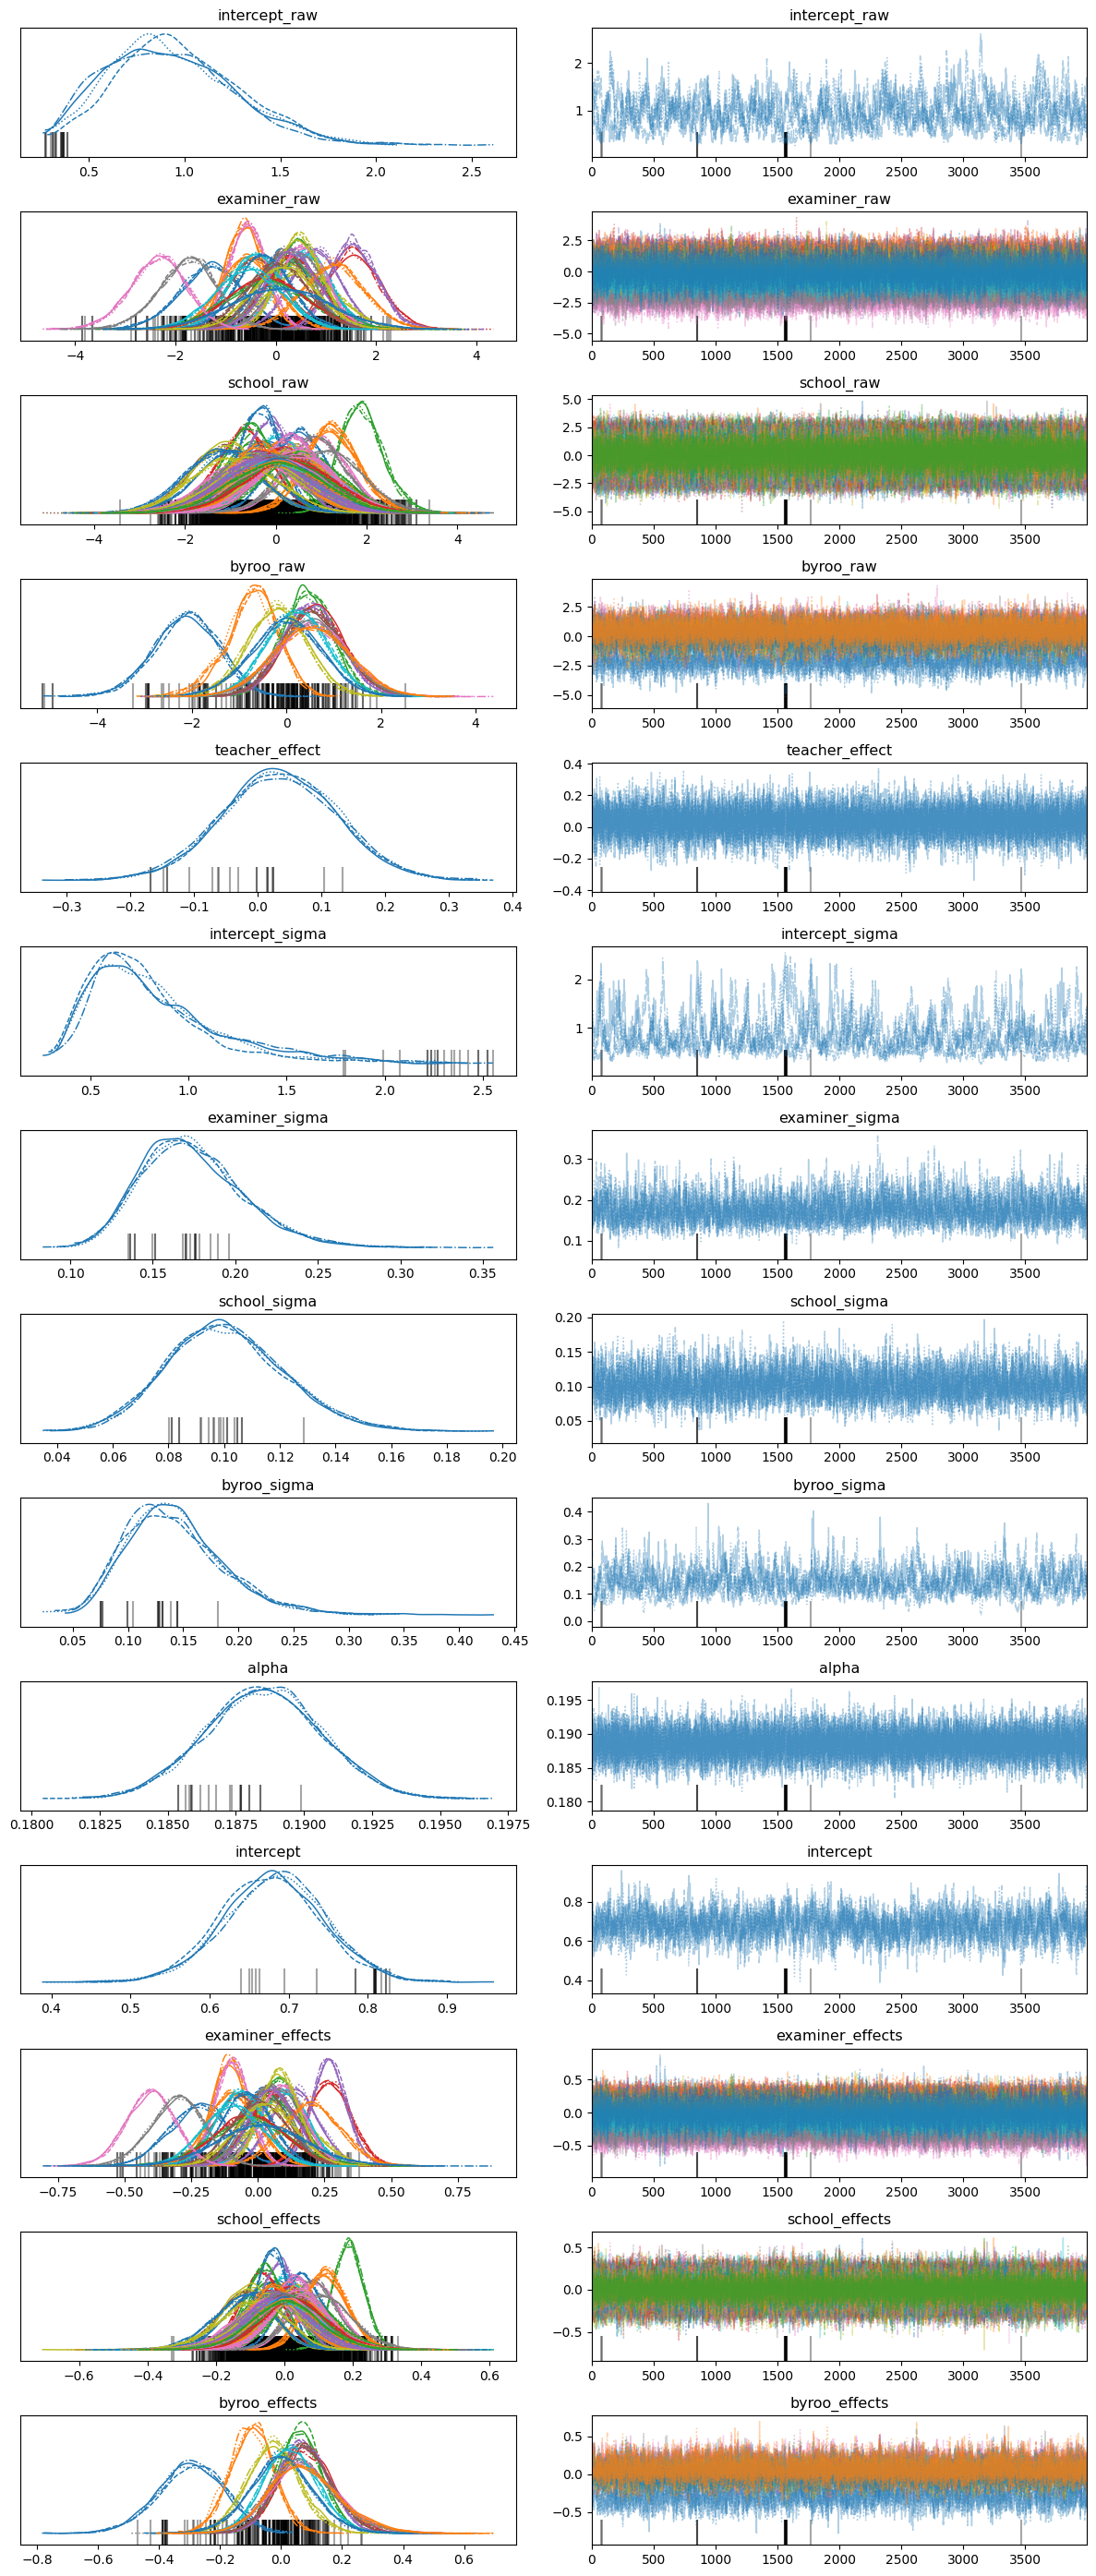

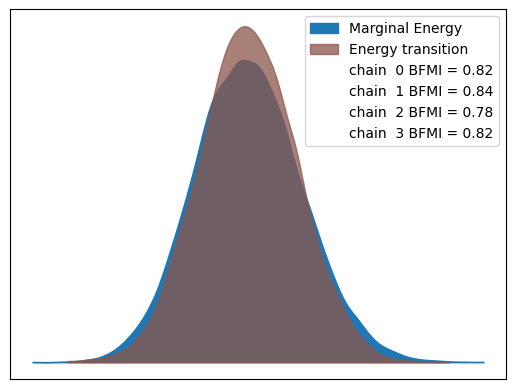


Number of divergent samples:
<xarray.DataArray 'diverging' ()> Size: 8B
array(21)


In [193]:
# Basic convergence diagnostics
print("\nModel Parameter Summary:")
summary = az.summary(trace, kind='diagnostics')

# Plot trace diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Plot energy diagnostics
az.plot_energy(trace)
plt.show()

# Check for divergences
print("\nNumber of divergent samples:")
print(trace.sample_stats.diverging.sum())

In [194]:
df_summary[df_summary.r_hat>1.01]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


## Save trace

In [195]:
trace.to_netcdf("models/soidueksam_a_kat_multiyear_v1.nc")

'models/soidueksam_a_kat_multiyear_v1.nc'

## Load trace

In [196]:
trace = az.from_netcdf("models/soidueksam_a_kat_multiyear_v1.nc")

## overall exam success

In [197]:
def get_average_success_probability(trace):
    # Get intercept (baseline)
    intercept = trace.posterior['intercept'].values
    
    # Convert to probability using inverse logit
    baseline_prob = 1 / (1 + np.exp(-intercept))
    results = {
        'mean': np.mean(baseline_prob),
        'std': np.std(baseline_prob),
        'lower_ci': np.percentile(baseline_prob, 2.5),
        'upper_ci': np.percentile(baseline_prob, 97.5)
    }
    
    print("Overall Success Probability:")
    print(f"Mean: {results['mean']:.3f}")
    print(f"95% CI: [{results['lower_ci']:.3f}, {results['upper_ci']:.3f}]")
    
    return results

average_prob = get_average_success_probability(trace)
average_prob

Overall Success Probability:
Mean: 0.664
95% CI: [0.635, 0.692]


{'mean': 0.6637674454918371,
 'std': 0.014397111759937097,
 'lower_ci': 0.6347308223446223,
 'upper_ci': 0.6915827775683653}

In [198]:
df_b_sub.y.mean()

0.7935539239057882

## Factors that contribute the most

<Figure size 1800x500 with 0 Axes>

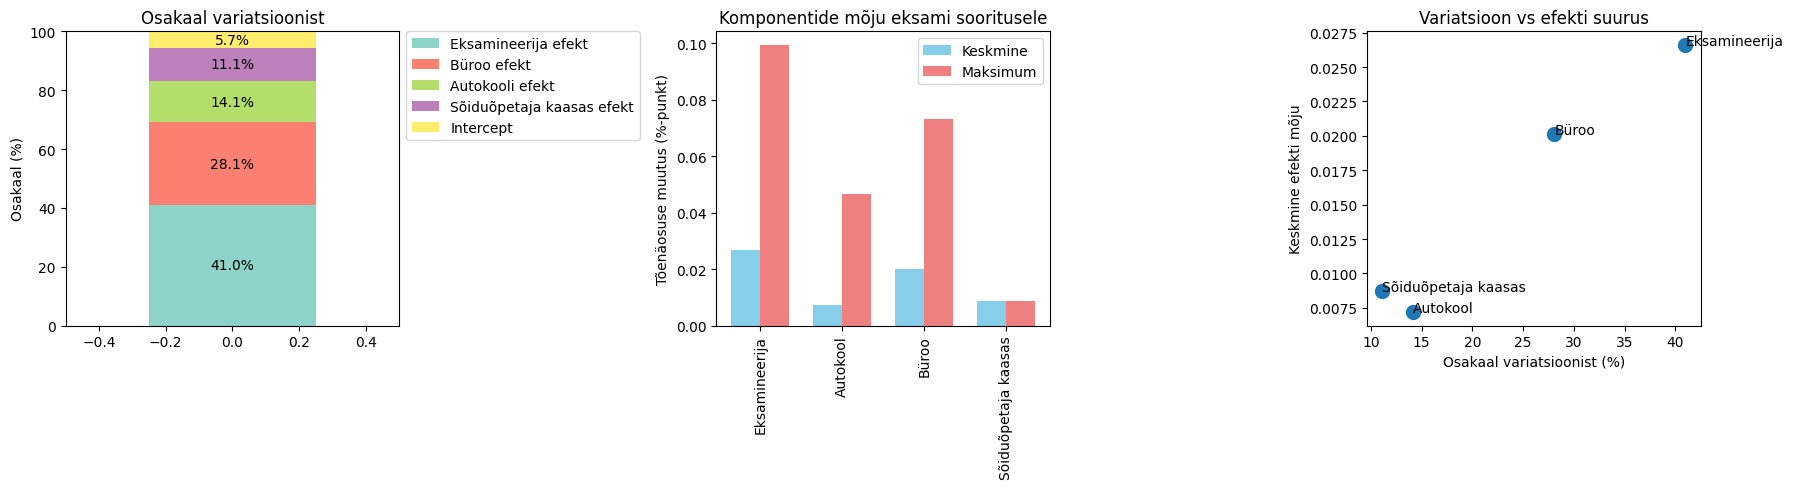

In [199]:
def analyze_component_contributions(trace):
    # Get components
    intercept_var = np.var(trace.posterior['intercept'].values)
    examiner_var = np.var(trace.posterior['examiner_effects'].values.reshape(-1))
    school_var = np.var(trace.posterior['school_effects'].values.reshape(-1))
    byroo_var = np.var(trace.posterior['byroo_effects'].values.reshape(-1))
    teacher_var = np.var(trace.posterior['teacher_effect'].values)
    
    # Calculate total variance
    total_var = (intercept_var + examiner_var + school_var + byroo_var + 
                 teacher_var )
    
    # Calculate proportions
    contributions = pd.Series({
        'Intercept': intercept_var/total_var,
        'Eksamineerija efekt': examiner_var/total_var,
        'Autokooli efekt': school_var/total_var,
        'Büroo efekt': byroo_var/total_var,
        'Sõiduõpetaja kaasas efekt': teacher_var/total_var,
    })
    
    return contributions * 100  # Convert to percentages

def logit_to_prob_change(effect):
    base_prob = 1 / (1 + np.exp(-0))  # 0.5
    new_prob = 1 / (1 + np.exp(-(0 + effect)))
    return new_prob - base_prob
    
    
def analyze_effect_sizes(trace, return_df=False):
    # Get absolute mean effects
    examiner_effects = np.abs(np.mean(trace.posterior['examiner_effects'].values, axis=(0,1)))
    school_effects = np.abs(np.mean(trace.posterior['school_effects'].values, axis=(0,1)))
    byroo_effects = np.abs(np.mean(trace.posterior['byroo_effects'].values, axis=(0,1)))
    teacher_effect = np.abs(np.mean(trace.posterior['teacher_effect'].values))

    result = {
        'Eksamineerija': {'mean': logit_to_prob_change(examiner_effects.mean()), 'max': logit_to_prob_change(examiner_effects.max())},
        'Autokool': {'mean': logit_to_prob_change(school_effects.mean()), 'max': logit_to_prob_change(school_effects.max())},
        'Büroo': {'mean': logit_to_prob_change(byroo_effects.mean()), 'max': logit_to_prob_change(byroo_effects.max())},
        'Sõiduõpetaja kaasas': {'mean': logit_to_prob_change(teacher_effect), 'max': logit_to_prob_change(teacher_effect)}
    }
    
    if return_df:
        return pd.DataFrame(result)
    return result

def plot_model_contributions(trace):
    # Get contributions
    contributions = analyze_component_contributions(trace)
    contributions=contributions.sort_values(ascending=False)
    
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # 1. Stacked Bar Plot
    plt.subplot(131)
    colors = plt.cm.Set3(np.linspace(0, 1, len(contributions)))
    
    # Create bars one by one to properly set up legend
    bottom = 0
    bars = []
    for i, (name, value) in enumerate(contributions.items()):
        bar = plt.bar(0, value, bottom=bottom, color=colors[i], width=0.5, label=name)
        plt.text(0, bottom + value/2, f'{value:.1f}%', ha='center', va='center')
        bottom += value
        bars.append(bar)
    
    plt.xlim(-0.5, 0.5)
    plt.ylim(0, 100)
    plt.ylabel('Osakaal (%)')
    plt.title('Osakaal variatsioonist')
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.02, 1), 
              loc='upper left',
              borderaxespad=0)
    
    # 2. Bar Plot with Effect Sizes
    effect_sizes = analyze_effect_sizes(trace)
    plt.subplot(132)
    components = list(effect_sizes.keys())
    means = [d['mean'] for d in effect_sizes.values()]
    maxes = [d['max'] for d in effect_sizes.values()]
    
    x = np.arange(len(components))
    width = 0.35
    
    plt.bar(x - width/2, means, width, label='Keskmine', color='skyblue')
    plt.bar(x + width/2, maxes, width, label='Maksimum', color='lightcoral')
    plt.xticks(x, components, rotation=90)
    plt.title('Komponentide mõju eksami sooritusele')
    plt.ylabel('Tõenäosuse muutus (%-punkt)')
    plt.legend()
    
    # 3. Scatter Plot: Variance vs Mean Effect
    plt.subplot(133)
    # Map component names to contribution names
    name_map = {
        'Eksamineerija': 'Eksamineerija efekt',
        'Büroo': 'Büroo efekt',
        'Autokool': 'Autokooli efekt',
        'Month': 'Month Effects',
        'Sõiduõpetaja kaasas':'Sõiduõpetaja kaasas efekt',
        'Eri101':'Eri101'
        
    }
    matched_contributions = [contributions[name_map[c]] for c in components]
    
    plt.scatter(matched_contributions, means, s=100)
    for i, txt in enumerate(components):
        plt.annotate(txt, (matched_contributions[i], means[i]))
    plt.xlabel('Osakaal variatsioonist (%)')
    plt.ylabel('Keskmine efekti mõju')
    plt.title('Variatsioon vs efekti suurus')
    
    plt.tight_layout()
    plt.show()
    
plot_model_contributions(trace)

## Visualize effect contributions

In [200]:
df_b_sub.columns

Index(['KUUPAEV', 'BYROO', 'ERITINGIMUSED', 'VIIMANE_AUTOKOOL',
       'SOIDUOPETAJA_KAASAS', 'EKSAMINEERIJA', 'SEISUND', 'y', 'y_transformed',
       'EKSAMINEERIJA_CLEAN', 'examiner_idx', 'school_idx', 'passed',
       'byroo_idx', 'teacher_present', 'teacher_present_c', 'pred_raw',
       'pred_sum', 'pred'],
      dtype='object')

In [201]:
df_b_sub=df_b_sub.reset_index(drop=True)


Probability changes:
Intercept: 0.164
Eksamineerija: -0.051
Autokool: 0.005
Büroo: -0.071
Sõiduõpetaja: -0.000

Final probability: 0.547
Actual outcome: 0.000


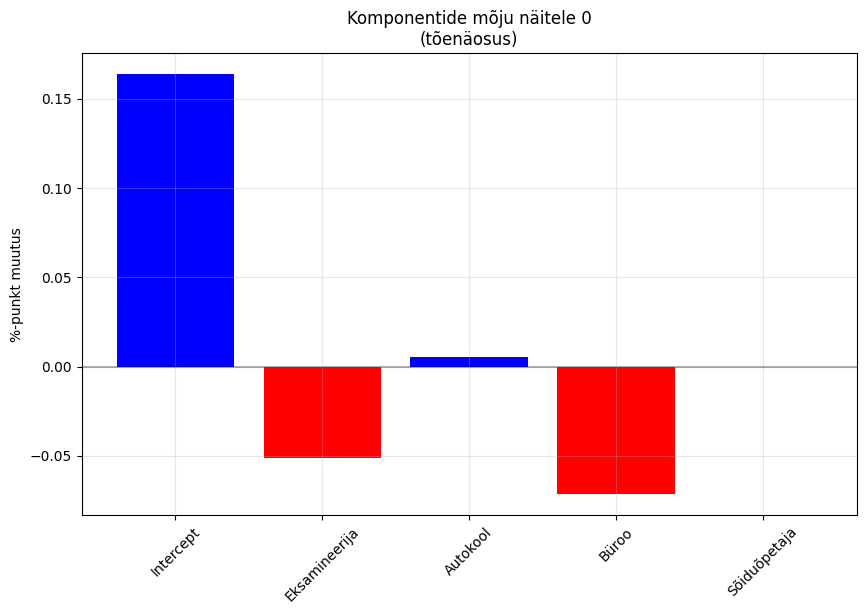

In [202]:
# Get posterior means
examiner_effects_mean = trace.posterior['examiner_effects'].mean(dim=('chain', 'draw'))
school_effects_mean = trace.posterior['school_effects'].mean(dim=('chain', 'draw'))
byroo_effects_mean = trace.posterior['byroo_effects'].mean(dim=('chain', 'draw'))
teacher_effect_mean = trace.posterior['teacher_effect'].mean(dim=('chain', 'draw'))
intercept_effect_mean = float(trace.posterior['intercept'].mean())

def plot_effects_breakdown_prob(sample_idx):
    # Get base effects (logit scale)
    effects = {
        'Intercept': intercept_effect_mean,
        'Eksamineerija': examiner_effects_mean[df_b_sub['examiner_idx'].iloc[sample_idx]],
        'Autokool': school_effects_mean[df_b_sub['school_idx'].iloc[sample_idx]],
        'Büroo': byroo_effects_mean[df_b_sub['byroo_idx'].iloc[sample_idx]],
        'Sõiduõpetaja' : teacher_effect_mean*df_b_sub['teacher_present_c'].iloc[sample_idx]
    }
    
    # Convert to probability changes
    prob_changes = {}
    cumulative = 0
    for k, v in effects.items():
        prev_prob = sp.expit(cumulative)
        cumulative += v
        new_prob = sp.expit(cumulative)
        prob_changes[k] = new_prob - prev_prob
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['blue' if v >= 0 else 'red' for v in prob_changes.values()]
    plt.bar(prob_changes.keys(), prob_changes.values(), color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Komponentide mõju näitele {sample_idx}\n(tõenäosus)')
    plt.ylabel('%-punkt muutus')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Print values
    print("\nProbability changes:")
    for k, v in prob_changes.items():
        print(f"{k}: {v:.3f}")
    print(f"\nFinal probability: {sp.expit(sum(effects.values())):.3f}")
    print(f"Actual outcome: {df_b_sub['y_transformed'].iloc[sample_idx]:.3f}")
    
plot_effects_breakdown_prob(0)


Probability changes:
Intercept: 0.164
Eksamineerija: -0.051
Autokool: -0.007
Büroo: -0.072
Sõiduõpetaja: -0.000

Final probability: 0.533
Actual outcome: 0.000


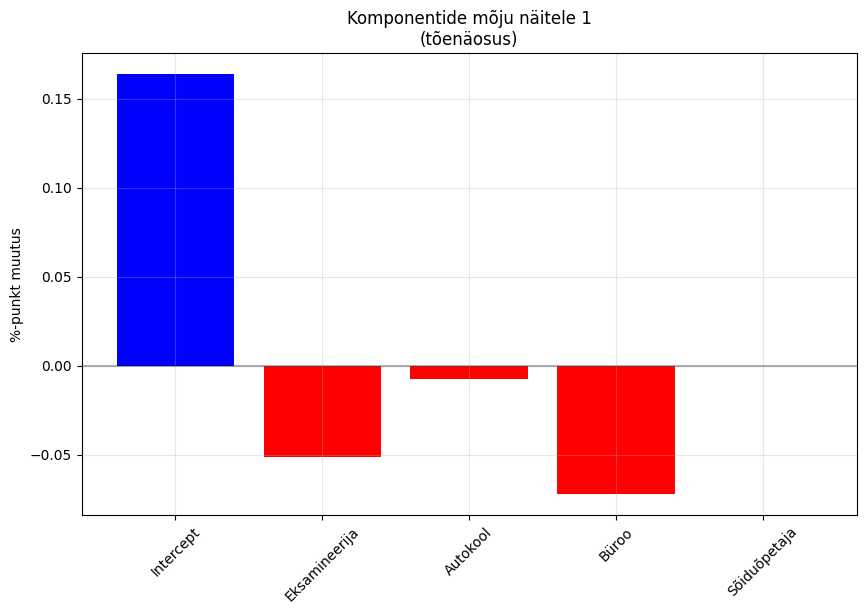

In [203]:
plot_effects_breakdown_prob(1)


Probability changes:
Intercept: 0.164
Eksamineerija: -0.022
Autokool: 0.020
Büroo: -0.006
Sõiduõpetaja: -0.000

Final probability: 0.657
Actual outcome: 1.000


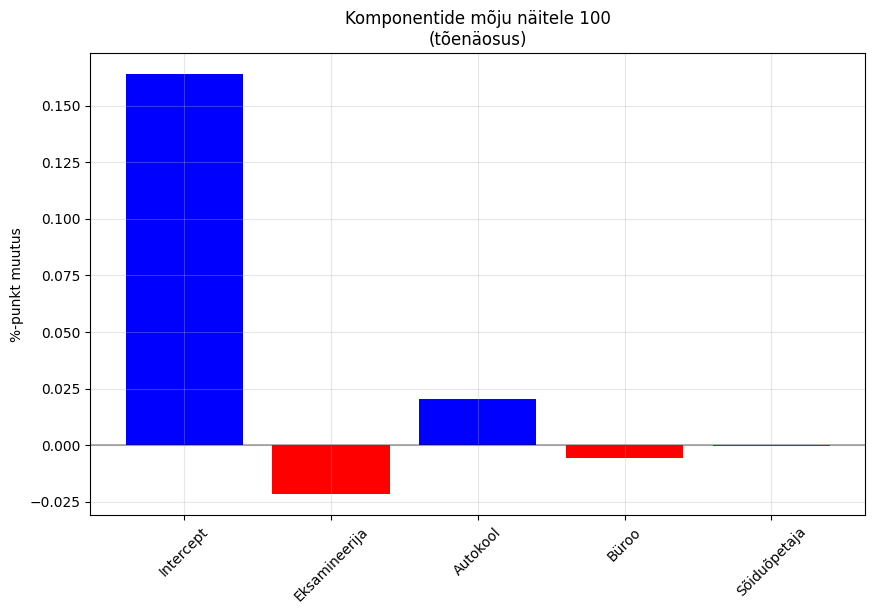

In [204]:
plot_effects_breakdown_prob(100)

## Examiner effects

In [205]:
examiner_bureau_max = pd.DataFrame(df_b_sub.groupby(['EKSAMINEERIJA'])['BYROO']
                      .value_counts()
                      .groupby(level=0)  # Group by examiner
                      .nlargest(1))    # Get largest count for each examiner
examiner_bureau_max.unstack()

count                               \
BYROO                             Rakvere Tallinn  Pärnu  Tartu  Jõhvi   
EKSAMINEERIJA    EKSAMINEERIJA                                           
075e15cf091d347b 075e15cf091d347b    40.0     NaN    NaN    NaN    NaN   
0f8b5f7ee00be8ae 0f8b5f7ee00be8ae     NaN   137.0    NaN    NaN    NaN   
12ed0758e403a7d6 12ed0758e403a7d6     NaN     NaN  279.0    NaN    NaN   
138291a4de4e3243 138291a4de4e3243     NaN     NaN    NaN    3.0    NaN   
147b5bf6bba0d0f1 147b5bf6bba0d0f1   152.0     NaN    NaN    NaN    NaN   
166c8268fe1b2ec1 166c8268fe1b2ec1     NaN     NaN    NaN    NaN   25.0   
16ff08c229c6ea58 16ff08c229c6ea58     NaN   296.0    NaN    NaN    NaN   
31451a368e962058 31451a368e962058     NaN     NaN    NaN    NaN    NaN   
32a030820e9d4091 32a030820e9d4091   208.0     NaN    NaN    NaN    NaN   
40bcf2cea820fca6 40bcf2cea820fca6     NaN     NaN    NaN  109.0    NaN   
4141299ff500eb11 4141299ff500eb11   123.0     NaN    NaN    NaN    NaN   
5c9ee299be483144 5c9ee299be483144     NaN   551.0    NaN    NaN    NaN   
5f2e29794998d365 5f2e29794998d365     NaN     NaN    NaN  299.0    NaN   
602d00a56a9a8757 602d00a56a9a8757     NaN     NaN    NaN  126.0    NaN   
9f3e3d07ecb6a86c 9f3e3d07ecb6a86c     NaN   277.0    NaN    NaN    NaN   
a37826c7bbe98142 a37826c7bbe98142     NaN     NaN    NaN    NaN    NaN   
a90a6cc35a006268 a90a6cc35a006268     NaN     NaN    NaN    NaN    NaN   
ae264be409f2ca9f ae264be409f2ca9f     NaN     NaN    NaN  594.0    NaN   
b353c311e671711a b353c311e671711a     NaN  1114.0    NaN    NaN    NaN   
b3e368548c216eb8 b3e368548c216eb8     NaN   987.0    NaN    NaN    NaN   
b7576201d47b425b b7576201d47b425b     NaN   205.0    NaN    NaN    NaN   
be39b89bc70a335e be39b89bc70a335e     NaN   344.0    NaN    NaN    NaN   
bf2b7218d36e2a3d bf2b7218d36e2a3d     NaN     NaN    NaN    NaN    NaN   
c347692cf48342d6 c347692cf48342d6     NaN     NaN  343.0    NaN    NaN   
cee792f71833b03b cee792f71833b03b     NaN     NaN    NaN  131.0    NaN   
d321254aa86edd96 d321254aa86edd96     NaN     NaN    NaN    NaN    NaN   
d67d168bc8d04278 d67d168bc8d04278     NaN     NaN    NaN    NaN  312.0   
e14095bf73a253c7 e14095bf73a253c7     NaN     NaN    NaN    NaN    NaN   
f6097462dafbd97c f6097462dafbd97c     NaN  1078.0    NaN    NaN    NaN   
faeaf99580d6be30 faeaf99580d6be30     NaN     NaN    NaN  278.0    NaN   
ff4d9b9b519322e3 ff4d9b9b519322e3     NaN     NaN  266.0    NaN    NaN   

                                                                              
BYROO                             Haapsalu  Rapla Kuressaare   Võru Viljandi  
EKSAMINEERIJA    EKSAMINEERIJA                                                
075e15cf091d347b 075e15cf091d347b      NaN    NaN        NaN    NaN      NaN  
0f8b5f7ee00be8ae 0f8b5f7ee00be8ae      NaN    NaN        NaN    NaN      NaN  
12ed0758e403a7d6 12ed0758e403a7d6      NaN    NaN        NaN    NaN      NaN  
138291a4de4e3243 138291a4de4e3243      NaN    NaN        NaN    NaN      NaN  
147b5bf6bba0d0f1 147b5bf6bba0d0f1      NaN    NaN        NaN    NaN      NaN  
166c8268fe1b2ec1 166c8268fe1b2ec1      NaN    NaN        NaN    NaN      NaN  
16ff08c229c6ea58 16ff08c229c6ea58      NaN    NaN        NaN    NaN      NaN  
31451a368e962058 31451a368e962058    117.0    NaN        NaN    NaN      NaN  
32a030820e9d4091 32a030820e9d4091      NaN    NaN        NaN    NaN      NaN  
40bcf2cea820fca6 40bcf2cea820fca6      NaN    NaN        NaN    NaN      NaN  
4141299ff500eb11 4141299ff500eb11      NaN    NaN        NaN    NaN      NaN  
5c9ee299be483144 5c9ee299be483144      NaN    NaN        NaN    NaN      NaN  
5f2e29794998d365 5f2e29794998d365      NaN    NaN        NaN    NaN      NaN  
602d00a56a9a8757 602d00a56a9a8757      NaN    NaN        NaN    NaN      NaN  
9f3e3d07ecb6a86c 9f3e3d07ecb6a86c      NaN    NaN        NaN    NaN      NaN  
a37826c7bbe98142 a37826c7bbe98142      NaN   67.0        NaN    NaN      NaN  
a90a6cc35a006268 a

In [206]:
examiner_bureau_max=examiner_bureau_max.reset_index(level=0) 
examiner_bureau_max.head()

,,EKSAMINEERIJA,count
EKSAMINEERIJA,BYROO,,
075e15cf091d347b,Rakvere,075e15cf091d347b,40
0f8b5f7ee00be8ae,Tallinn,0f8b5f7ee00be8ae,137
12ed0758e403a7d6,Pärnu,12ed0758e403a7d6,279
138291a4de4e3243,Tartu,138291a4de4e3243,3
147b5bf6bba0d0f1,Rakvere,147b5bf6bba0d0f1,152


Number of examiner_idx with significant positive effect: 2
Number of examiner_idx with significant negative effect: 3


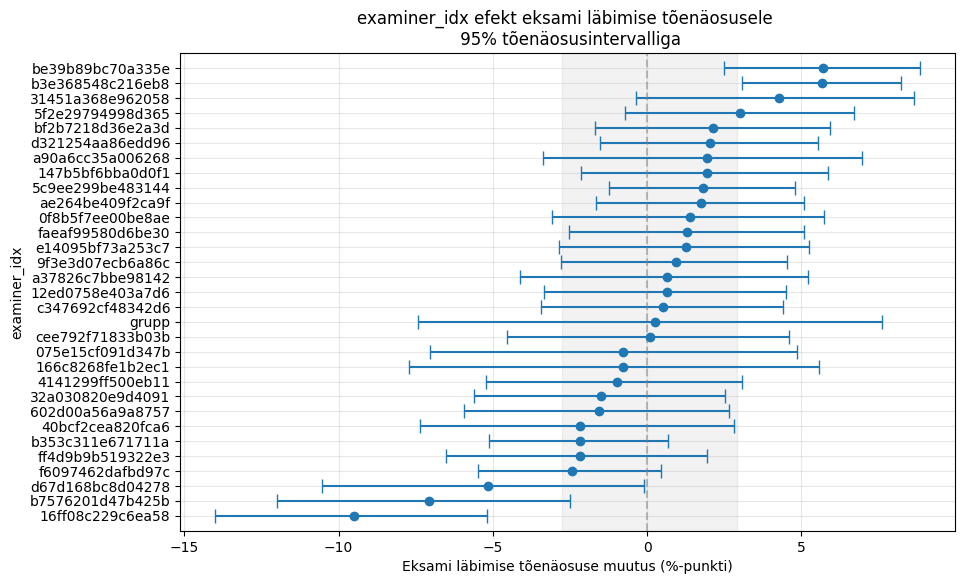

In [207]:
def plot_effects(y_labels_col='examiner_idx', effects_key='examiner_effects', only_significant=False,
                y_dict=None, return_data=False):
# Get all samples for examiner effects
    examiner_samples = trace.posterior[effects_key]
    
    # Get examiner IDs (assuming they're in the original order in df_b_sub)
    examiner_ids = df_b_sub[y_labels_col].unique()
    
    # Calculate mean and HDI for each examiner
    means = []
    hdis = []
    ids = []  # Store IDs in same order as effects
    labels=[]
    
     # Convert logit effects to probability changes
    base_prob = sp.expit(intercept_effect_mean)
    # Calculate baseline CI once
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    for i in range(examiner_samples.shape[2]):
        effect_samples = examiner_samples[:, :, i].values.flatten()
        prob_changes = sp.expit(intercept_effect_mean + effect_samples) - base_prob
        percentiles = np.percentile(prob_changes, [2.5, 97.5])
        
        # Check for significance considering baseline CI overlap
        is_significant = False
        if percentiles[1] < -base_ci[1] + base_prob:  # Significantly negative
            is_significant = True
        elif percentiles[0] > -base_ci[0] + base_prob:  # Significantly positive
            is_significant = True
            
        if only_significant and is_significant:
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
        elif not only_significant:
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
    
    # Sort by mean effect
    sorted_indices = np.argsort(means)
    means = np.array(means)[sorted_indices]
    hdis = np.array(hdis)[sorted_indices]
    ids = np.array(ids)[sorted_indices]
    if len(labels)>0:
        labels = np.array(labels)[sorted_indices]
    
    # Calculate confidence interval for baseline probability
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    # Plot
    plt.figure(figsize=(10, len(means)*0.2))
    
    # Add shaded confidence interval around zero
    plt.axvspan((-base_ci[1] + base_prob)*100, (-base_ci[0] + base_prob)*100, 
                color='grey', alpha=0.1, label='Baseline CI')
    
    # Plot effects
    plt.errorbar(means*100, range(len(means)),
                xerr=[(means - hdis[:, 0])*100, (hdis[:, 1] - means)*100],
                fmt='o', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
       
    if y_dict is not None:
        plt.yticks(range(len(means)), labels)
    else:
        plt.yticks(range(len(means)), ids)
    plt.ylim(-1.0, len(means))  # This removes the extra space
    
    plt.ylabel(y_labels_col)
    plt.xlabel('Eksami läbimise tõenäosuse muutus (%-punkti)')
    plt.title(f'{y_labels_col} efekt eksami läbimise tõenäosusele \n 95% tõenäosusintervalliga')
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print(f"Number of {y_labels_col} with significant positive effect: {sum(hdis[:, 0] > 0)}")
    print(f"Number of {y_labels_col} with significant negative effect: {sum(hdis[:, 1] < 0)}")
    if return_data:
        df=pd.DataFrame(hdis)
        df.columns=['low', 'high']
        df['mean']=means
        df['id']=ids
        if len(labels)>0:
            df['label']=labels
        return df
    
df_examiner=plot_effects(y_dict=idx_to_examiner, return_data=True)

Number of examiner_idx with significant positive effect: 1
Number of examiner_idx with significant negative effect: 1


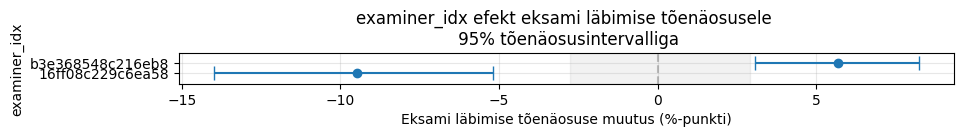

In [208]:
plot_effects(y_dict=idx_to_examiner, only_significant=True, return_data=False)

In [209]:
df_examiner_count=pd.DataFrame(df_b_sub['EKSAMINEERIJA'].value_counts())
df_examiner_count.shape

(31, 1)

In [210]:
df_examiner=df_examiner.merge(df_examiner_count, left_on='label', right_index=True, how='left')
df_examiner=df_examiner.merge(examiner_bureau_max[['count']].reset_index(),  left_on='label', right_on='EKSAMINEERIJA', how='left')
df_examiner.shape

(31, 9)

<Axes: xlabel='mean', ylabel='count_x'>

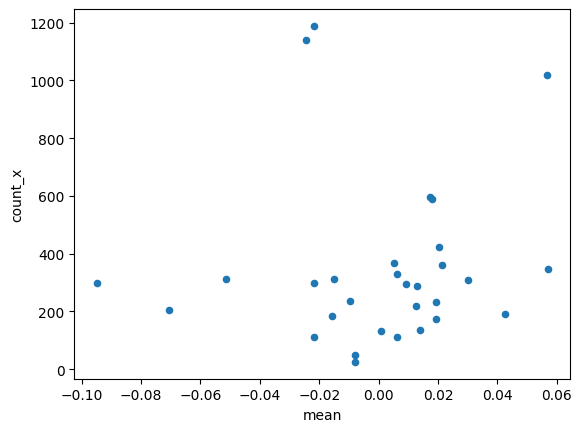

In [211]:
#number of exams vs mean effect
df_examiner.plot.scatter('mean', 'count_x')

/tmp/ipykernel_204/3790301084.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df_examiner[mask]['mean'],


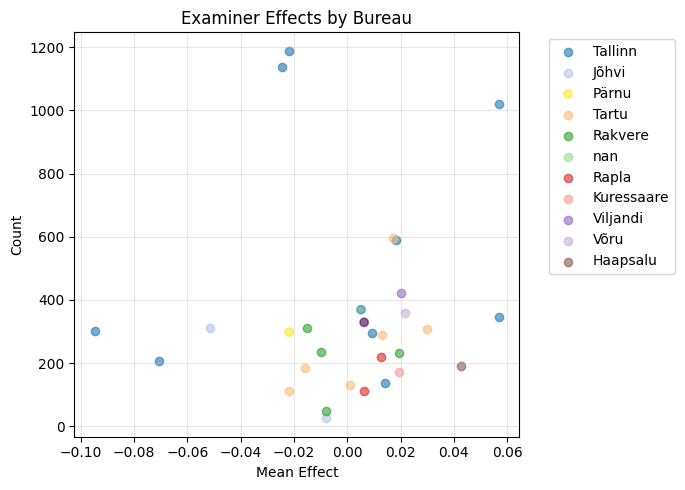

In [212]:
# Create color mapping for BYROO
unique_byroos = df_examiner['BYROO'].unique()
color_map = dict(zip(unique_byroos, plt.cm.tab20.colors[:len(unique_byroos)]))

# Create the plot
plt.figure(figsize=(7, 5))
for byroo in unique_byroos:
    mask = df_examiner['BYROO'] == byroo
    plt.scatter(df_examiner[mask]['mean'], 
               df_examiner[mask]['count_x'],
               label=byroo,
               c=color_map[byroo],
               alpha=0.6)

plt.xlabel('Mean Effect')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Examiner Effects by Bureau')
plt.grid(True, alpha=0.3)
plt.tight_layout()

## School effects

In [213]:
df_b_sub.VIIMANE_AUTOKOOL.str.lower().nunique()

123

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

/usr/local/lib/python3.11/dist-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/usr/local/lib/python3.11/dist-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/usr/local/lib/python3.11/dist-packages/matplotlib/patches.py:739: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:2050: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty


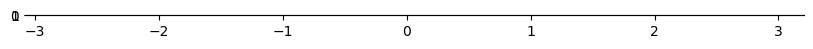

In [214]:
df_school=plot_effects(y_labels_col='school_idx', effects_key='school_effects', only_significant=True,
             y_dict=idx_to_school, return_data=True)

In [215]:
df_school.sort_values('mean')

,low,high,mean,id,label
0,-0.070937,0.008831,-0.027979,50,osaühing yungman
1,-0.065759,0.007677,-0.026128,35,oü valkrus
2,-0.064330,0.007852,-0.025741,38,osaühing laplaravia
3,-0.071896,0.018640,-0.022281,68,osaühing autkol
4,-0.061760,0.014387,-0.021144,40,osaühing unomar grupp
...,...,...,...,...,...
118,-0.009703,0.049738,0.019630,16,osaühing aide autokool
119,-0.011068,0.062342,0.024068,47,oü gestani
120,-0.000305,0.052403,0.025856,21,ametikoolitus oü
121,0.002949,0.052142,0.027360,41,autokool drive oü


Number of school_idx with significant positive effect: 2
Number of school_idx with significant negative effect: 0


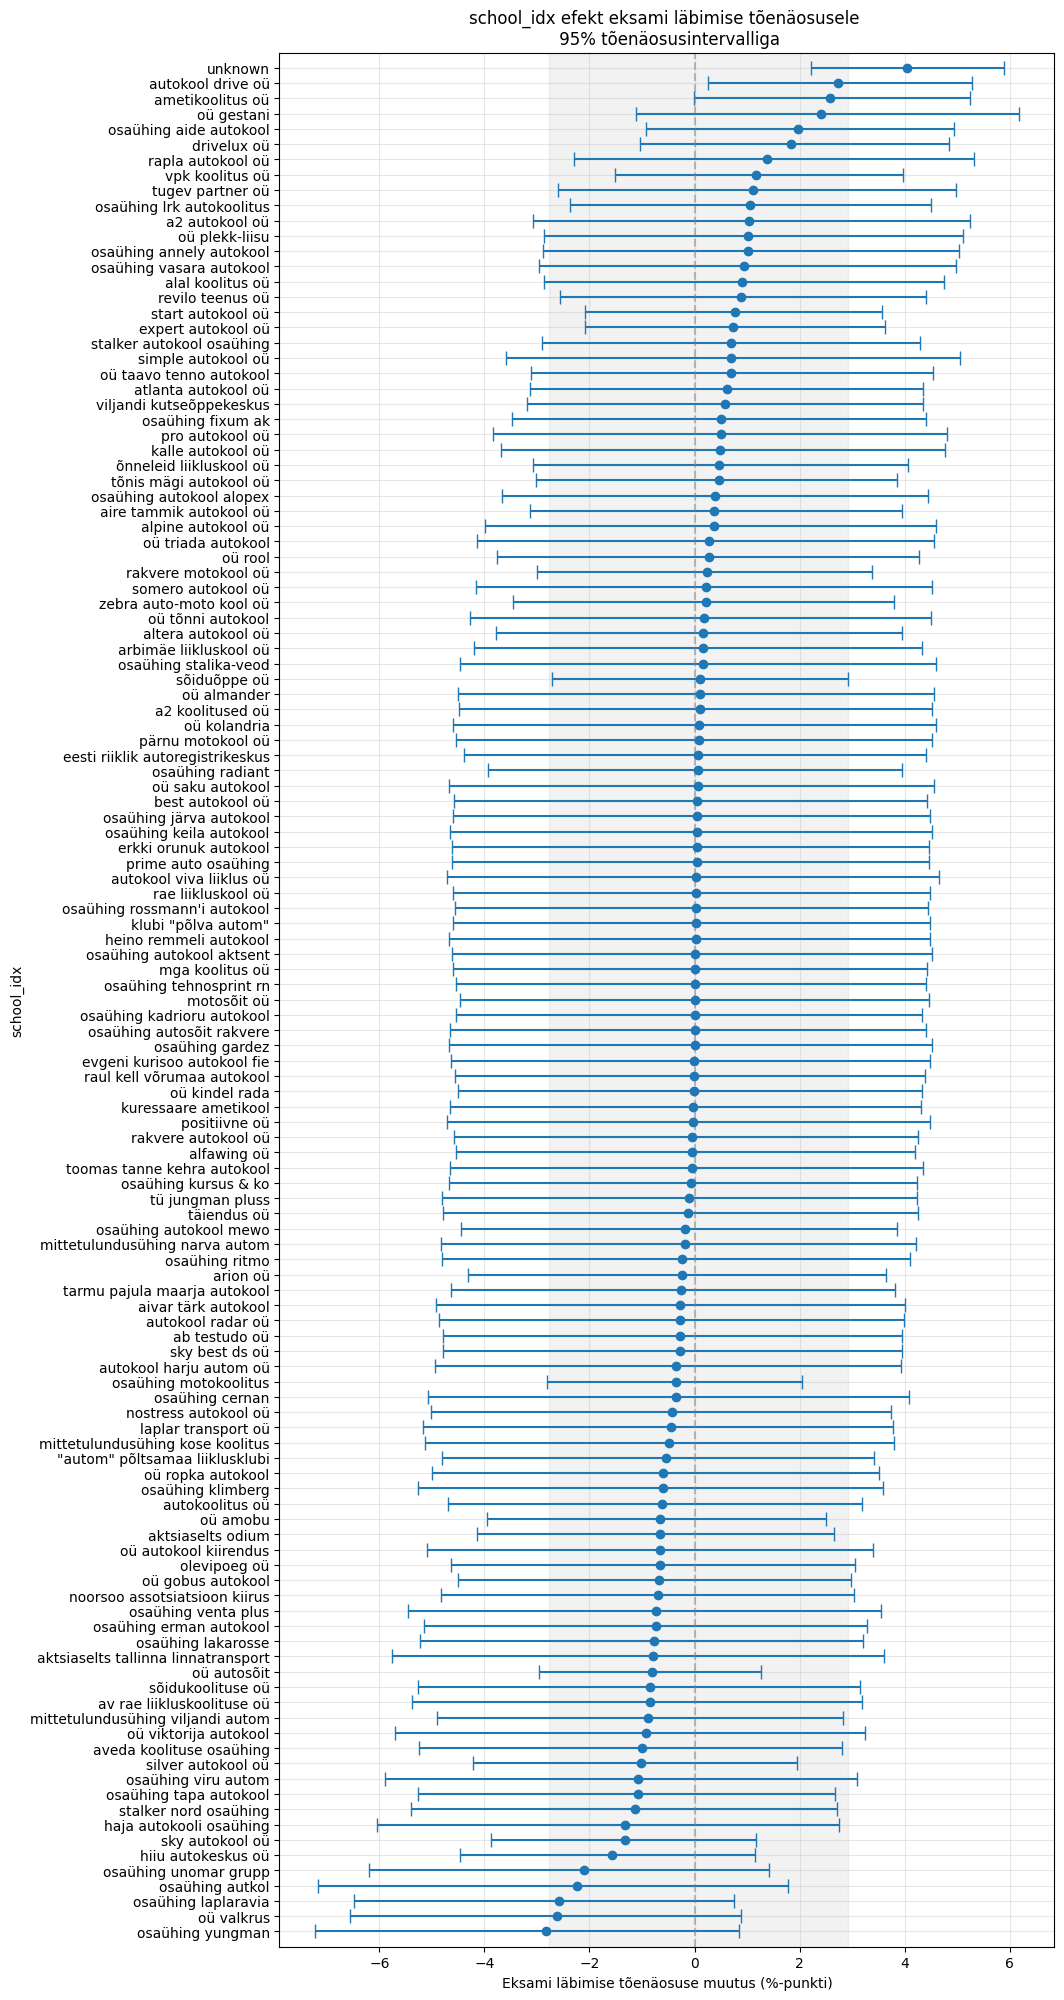

In [216]:
df_school=plot_effects(y_labels_col='school_idx', effects_key='school_effects', only_significant=False,
             y_dict=idx_to_school, return_data=True)

## Büroo effects

Number of byroo_idx with significant positive effect: 0
Number of byroo_idx with significant negative effect: 1


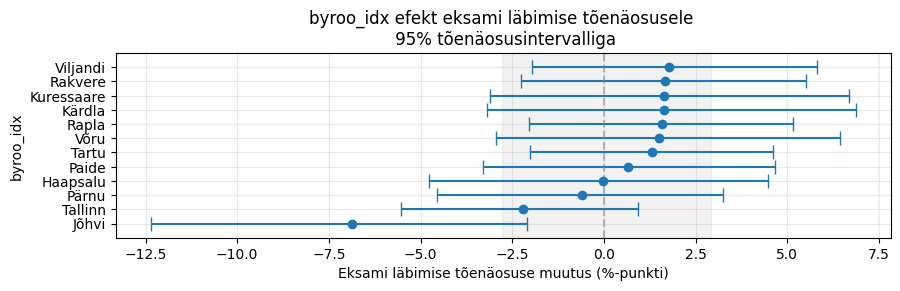

In [217]:
plot_effects(y_labels_col='byroo_idx', effects_key='byroo_effects', only_significant=False,
             y_dict=idx_to_byroo)

## Teacher present

In [218]:
def plot_binary_effects(binary_effects=['teacher_effect'],
                       effect_labels=['Sõiduõpetaja kaasas']):
    # Calculate mean and HDI for each binary effect
    means = []
    hdis = []
    
    # Convert logit effects to probability changes
    base_prob = sp.expit(intercept_effect_mean)
    
    for effect_name in binary_effects:
        effect_samples = trace.posterior[effect_name].values.flatten()
        prob_changes = sp.expit(intercept_effect_mean + effect_samples) - base_prob
        
        means.append(np.mean(prob_changes))
        hdis.append(np.percentile(prob_changes, [2.5, 97.5]))
    
    # Convert to arrays
    means = np.array(means)
    hdis = np.array(hdis)
    
    # Calculate confidence interval for baseline probability
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    # Plot
    plt.figure(figsize=(10, len(means)*0.5))
    
    # Add shaded confidence interval around zero
    plt.axvspan((-base_ci[1] + base_prob)*100, (-base_ci[0] + base_prob)*100, 
                color='grey', alpha=0.1, label='Baseline CI')
    
    # Plot effects
    plt.errorbar(means*100, range(len(means)),
                xerr=[(means - hdis[:, 0])*100, (hdis[:, 1] - means)*100],
                fmt='o', capsize=5, markersize=10)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
    
    # Add effect labels
    plt.yticks(range(len(means)), effect_labels)
    plt.ylim(-0.5, len(means)-0.5)
    
    # plt.ylabel('Binary Effects')
    plt.xlabel('Eksami läbimise tõenäosuse muutus (%-punkti)')
    plt.title('mõju eksami läbimise tõenäosusele \n 95% tõenäosusintervalliga')
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print("Significant effects:")
    for label, hdi in zip(effect_labels, hdis):
        if hdi[0] > 0:
            print(f"{label}: Significant positive effect")
        elif hdi[1] < 0:
            print(f"{label}: Significant negative effect")
        else:
            print(f"{label}: No significant effect")

Significant effects:
Sõiduõpetaja kaasas: No significant effect


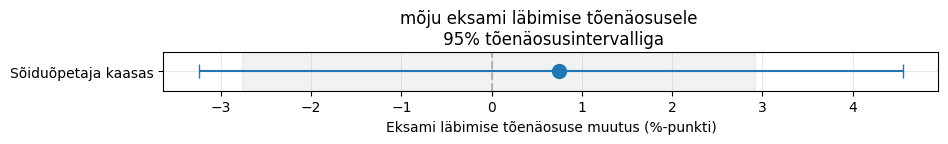

In [219]:
plot_binary_effects()

## Predict on training data to get estimate on accuracy

In [220]:
# Get posterior means
examiner_effects_mean = trace.posterior['examiner_effects'].mean(dim=('chain', 'draw'))
school_effects_mean = trace.posterior['school_effects'].mean(dim=('chain', 'draw'))
byroo_effects_mean = trace.posterior['byroo_effects'].mean(dim=('chain', 'draw'))
teacher_effect_mean = trace.posterior['teacher_effect'].mean(dim=('chain', 'draw'))
intercept_effect_mean = float(trace.posterior['intercept'].mean())

def effects_breakdown_prob(sample_idx):
    # Get base effects (logit scale)
    effects = {
        'Intercept': intercept_effect_mean,
        'Examiner': examiner_effects_mean[df_b_sub['examiner_idx'].iloc[sample_idx]],
        'School': school_effects_mean[df_b_sub['school_idx'].iloc[sample_idx]],
        'Bureau': byroo_effects_mean[df_b_sub['byroo_idx'].iloc[sample_idx]],
        'Teacher' : teacher_effect_mean*df_b_sub['teacher_present_c'].iloc[sample_idx]
    }
    
    # Convert to probability changes
    prob_changes = {}
    cumulative = 0
    for k, v in effects.items():
        prev_prob = sp.expit(cumulative)
        cumulative += v
        new_prob = sp.expit(cumulative)
        res= (new_prob - prev_prob)
        if k=='Intercept':
            prob_changes[k] = res#[0]
        else:
            prob_changes[k] = float(res.data)#[0]
            
    
    return prob_changes


In [221]:
preds=[]
for i in range(df_b_sub.shape[0]):
    res_=effects_breakdown_prob(i)
    preds.append(res_)

In [222]:
df_b_sub['pred_raw']=preds
df_b_sub['pred_sum']=df_b_sub['pred_raw'].apply(lambda x: np.sum(list(x.values())))
df_b_sub['pred']=np.where(df_b_sub['pred_sum']>0., 1, 0)

In [223]:
np.sum(list(res_.values()))

0.14700583071866424

In [224]:
print(classification_report(df_b_sub.y, df_b_sub.pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2165
         1.0       0.79      1.00      0.88      8322

    accuracy                           0.79     10487
   macro avg       0.40      0.50      0.44     10487
weighted avg       0.63      0.79      0.70     10487



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## individual max effects

In [89]:
pd.DataFrame(df_b_sub.pred_raw.tolist())

,Intercept,Examiner,School,Bureau,Teacher
0,0.113692,-0.022591,-0.035334,-0.032534,0.000170
1,0.113692,-0.015053,-0.035163,-0.032446,0.000170
2,0.113692,0.014148,0.023906,0.020434,0.000150
3,0.113692,0.014148,0.023906,0.020434,0.000150
4,0.113692,0.041898,0.012223,0.021471,0.000146
...,...,...,...,...,...
23147,0.113692,0.014148,-0.015270,0.021442,0.000158
23148,0.113692,0.042574,0.007543,-0.029764,0.000158
23149,0.113692,-0.012103,0.018718,-0.018706,0.000163
23150,0.113692,-0.035700,-0.015889,-0.019459,0.000169


## Save model data

In [51]:
# def clean_name_for_js(name):
#     """Clean names for JavaScript use, preserving Estonian characters"""
#     if pd.isna(name):
#         return "Unknown"
    
#     # Convert to string if not already
#     name = str(name)
    
#     # Preserve Estonian characters while replacing problematic ones
#     estonian_chars = {
#         'õ': 'õ', 'ä': 'ä', 'ö': 'ö', 'ü': 'ü',
#         'Õ': 'Õ', 'Ä': 'Ä', 'Ö': 'Ö', 'Ü': 'Ü',
#         'š': 'š', 'ž': 'ž', 'Š': 'Š', 'Ž': 'Ž'
#     }
    
#     # Replace problematic characters but keep Estonian ones
#     replacements = {
#         # '"': '&quot;',
#         # "'": '&apos;',
#         '<': '&lt;',
#         '>': '&gt;',
#         '\\': '',
#         '\n': ' ',
#         '\r': ' ',
#         '\t': ' '
#     }
    
#     # First preserve Estonian characters
#     for est_char in estonian_chars:
#         name = name.replace(est_char, f"____{est_char}____")
    
#     # Then replace problematic characters
#     for char, replacement in replacements.items():
#         name = name.replace(char, replacement)
    
#     # Restore Estonian characters
#     for est_char in estonian_chars:
#         name = name.replace(f"____{est_char}____", est_char)
    
#     # Remove multiple spaces
#     name = ' '.join(name.split())
    
#     return name

# def save_model_to_json(trace, output_file='model_data.js', ci_width=0.95):
#     # Get all samples for uncertainty calculations
#     examiner_samples = trace.posterior['examiner_effects'].values
#     school_samples = trace.posterior['school_effects'].values
#     byroo_samples = trace.posterior['byroo_effects'].values
#     teacher_samples = trace.posterior['teacher_effect'].values
#     intercept_samples = trace.posterior['intercept'].values
    
#     def get_effect_stats(samples):
#         mean = np.mean(samples, axis=(0,1))
#         ci_lower = np.percentile(samples, (1-ci_width)*100/2, axis=(0,1))
#         ci_upper = np.percentile(samples, 100-(1-ci_width)*100/2, axis=(0,1))
#         return mean, ci_lower, ci_upper
    
#     # Get effects and CIs
#     examiner_effects, examiner_ci_lower, examiner_ci_upper = get_effect_stats(examiner_samples)
#     school_effects, school_ci_lower, school_ci_upper = get_effect_stats(school_samples)
#     byroo_effects, byroo_ci_lower, byroo_ci_upper = get_effect_stats(byroo_samples)
    
#     examiner_map = {idx: clean_name_for_js(name) 
#                    for idx, name in enumerate(df_b_sub['EKSAMINEERIJA'].unique())}
#     school_map = {idx: clean_name_for_js(name) 
#                  for idx, name in enumerate(df_b_sub['VIIMANE_AUTOKOOL'].unique())}
#     byroo_map = {idx: clean_name_for_js(name) 
#                 for idx, name in enumerate(df_b_sub['BYROO'].unique())}
    
#     model_data = {
#         'intercept': float(np.mean(intercept_samples)),
#         'intercept_ci': [float(np.percentile(intercept_samples, 2.5)), 
#                         float(np.percentile(intercept_samples, 97.5))],
#         'examiner_effects': {
#             examiner_map[i]: {
#                 'effect': float(effect),
#                 'ci_lower': float(ci_lower),
#                 'ci_upper': float(ci_upper)
#             } for i, (effect, ci_lower, ci_upper) in enumerate(zip(examiner_effects, 
#                                                                  examiner_ci_lower, 
#                                                                  examiner_ci_upper))
#         },
#         'school_effects': {  # Add school effects
#             school_map[i]: {
#                 'effect': float(effect),
#                 'ci_lower': float(ci_lower),
#                 'ci_upper': float(ci_upper)
#             } for i, (effect, ci_lower, ci_upper) in enumerate(zip(school_effects, 
#                                                                  school_ci_lower, 
#                                                                  school_ci_upper))
#         },
#         'byroo_effects': {  # Add byroo effects
#             byroo_map[i]: {
#                 'effect': float(effect),
#                 'ci_lower': float(ci_lower),
#                 'ci_upper': float(ci_upper)
#             } for i, (effect, ci_lower, ci_upper) in enumerate(zip(byroo_effects, 
#                                                                  byroo_ci_lower, 
#                                                                  byroo_ci_upper))
#         },
#         'teacher_effect': float(np.mean(teacher_samples)),
#         'teacher_ci': [float(np.percentile(teacher_samples, 2.5)), 
#                       float(np.percentile(teacher_samples, 97.5))],
#         'teacher_mean': float(df_b_sub['teacher_present_c'].mean()),
#         'examiner_names': list(examiner_map.values()),
#         'school_names': list(school_map.values()),
#         'byroo_names': list(byroo_map.values())
#     }

#     with open(output_file, 'w', encoding='utf-8') as f:  # Note: utf-8 encoding
#         f.write('const modelData = ')
#         json.dump(model_data, f, indent=2, ensure_ascii=False)  # ensure_ascii=False for proper encoding
#         f.write(';')

        
# save_model_to_json(trace)